In [1]:
!pip install --quiet nltk
!pip install --quiet bs4
!pip install --quiet tqdm
!pip install --quiet scipy scikit-learn keras-tuner
!pip install --quiet keras-tuner

In [2]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm
import numpy as np

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading in the data and preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()

file_path = 'data.csv'
df = pd.read_csv(file_path)

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words and lemmatize
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    
    return cleaned_text

# Apply the cleaning function with progress bars
tqdm.pandas()

In [ ]:
# Apply the cleaning function to both the 'article' and 'highlights' columns
df['cleaned_article'] = df['article'].progress_apply(clean_text)

In [ ]:
df['cleaned_highlights'] = df['highlights'].progress_apply(clean_text)

In [ ]:
cleaned_file_path = 'cleaned_data.csv'

In [ ]:
df.to_csv(cleaned_file_path, index=False)

## Loading in our preprocessed df

ubuntu commands required to load in the file uploaded to github using the large file system.
sudo apt-get update
sudo apt-get install git-lfs
git lfs install
git lfs pull


In [36]:
df = pd.read_csv('cleaned_data.csv')
#df = df.sample(100000, random_state =42)
df.head()

,id,cleaned_article,cleaned_highlights
0,1211a23db42e7dd52a43e564a899ebbf1b2d1251,daily mail reporter published est june updated...,president barack obamas top national security ...
1,aff92aa2fc6e294efeeed70e9b0a0aefac32b030,lizzie parry mailonline young cancer victim to...,sophie walton diagnosed bone cancer discoverin...
2,bb7757b7bf3d90ec4f1d1915a4699eecafc25d1a,rebel aided al qaedalinked militant seized con...,israeli military closed area around crossing o...
3,8f25b2c54cb563b98e1f2619401df7137a3f0c77,cnn two right group launched stinging critique...,new trial resume kremlin critic aleksei navaln...
4,daa6ca8fe860fa70bed00e2bfd05ab7414b7cb0e,cnn puffing electronic cigarette already nono ...,government proposes explicitly ban use electro...


In [37]:
!pip install --quiet tensorflow

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Mapping words onto numbers using the Tensorflow Tokenizer

What should the vocab_size be?

In [39]:
combined_texts = df.cleaned_article.tolist() + df.cleaned_highlights.tolist()

In [101]:
from collections import Counter
def count_oov_in_text(tokenized_text, oov_token_index):
    return sum(1 for token in tokenized_text if token == oov_token_index)

def calculate_metrics(vocab_size):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(combined_texts)
    
    # Tokenize articles and summaries with the tokenizer
    tokenized_articles = tokenizer.texts_to_sequences(df.cleaned_article)
    tokenized_summaries = tokenizer.texts_to_sequences(df.cleaned_highlights)
    
    word_counts = tokenizer.word_counts
    total_words = sum(word_counts.values())
    
    most_common_words = Counter(word_counts).most_common(vocab_size)
    coverage = sum([count for word, count in most_common_words]) / total_words
    
    oov_token_index = tokenizer.word_index.get('<OOV>')
    
    oov_counts_articles = [count_oov_in_text(text, oov_token_index) for text in tokenized_articles]
    oov_counts_summaries = [count_oov_in_text(text, oov_token_index) for text in tokenized_summaries]
    
    # OOV proportions
    total_count_articles = sum(len(seq) for seq in tokenized_articles)
    total_count_summaries = sum(len(seq) for seq in tokenized_summaries)
    oov_count_articles = sum(oov_counts_articles)
    oov_count_summaries = sum(oov_counts_summaries)
    
    oov_proportion_articles = oov_count_articles / total_count_articles
    oov_proportion_summaries = oov_count_summaries / total_count_summaries
    
    # Overall OOV proportion
    total_oov_count = oov_count_articles + oov_count_summaries
    total_token_count = total_count_articles + total_count_summaries
    overall_oov_proportion = total_oov_count / total_token_count
    
    avg_oov_articles = np.mean(oov_counts_articles)
    avg_oov_summaries = np.mean(oov_counts_summaries)
    
    return {
        "vocab_size": vocab_size,
        "coverage": coverage,
        "oov_proportion_articles": oov_proportion_articles,
        "oov_proportion_summaries": oov_proportion_summaries,
        "overall_oov_proportion": overall_oov_proportion,
        "avg_oov_articles": avg_oov_articles,
        "avg_oov_summaries": avg_oov_summaries
    }

vocab_sizes = [10000, 15000, 20000, 25000, 30000]

# Calculate metrics for each vocab size
results = []
for vocab_size in vocab_sizes:
    metrics = calculate_metrics(vocab_size)
    results.append(metrics)

results_df = pd.DataFrame(results)

In [102]:
results_df

,vocab_size,coverage,oov_proportion_articles,oov_proportion_summaries,overall_oov_proportion,avg_oov_articles,avg_oov_summaries
0,10000,0.884074,0.115669,0.119463,0.115946,43.93360,3.57063
1,15000,0.918544,0.081365,0.082738,0.081465,30.90435,2.47295
2,20000,0.937633,0.062379,0.062293,0.062373,23.69294,1.86186
3,25000,0.949642,0.050414,0.049693,0.050362,19.14843,1.48527
4,30000,0.957886,0.042175,0.041370,0.042117,16.01911,1.23652


In [40]:
vocab_size = 16500
shared_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
shared_tokenizer.fit_on_texts(combined_texts)

# Tokenize articles and summaries with the shared tokenizer
tokenized_article = shared_tokenizer.texts_to_sequences(df.cleaned_article)
tokenized_summary = shared_tokenizer.texts_to_sequences(df.cleaned_highlights)

### Potential outlier detection

In [41]:
max_article_len = max(len(sequence) for sequence in tokenized_article)
max_summary_len = max(len(sequence) for sequence in tokenized_summary)

print(max_article_len, max_summary_len)

1828 717


/tmp/ipykernel_28156/4072075555.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Article Length', data=lengths_df, palette='Set2')
/tmp/ipykernel_28156/4072075555.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Summary Length', data=lengths_df, palette='Set2')


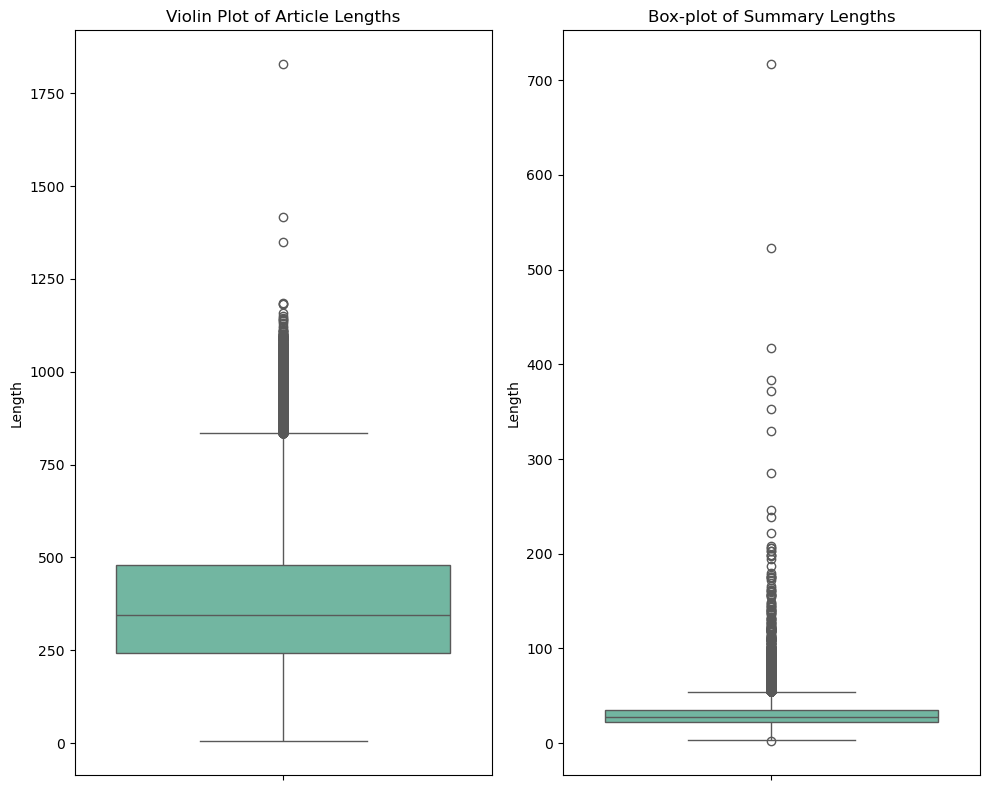

In [42]:
import matplotlib.pyplot as plt
!pip install --quiet seaborn
import seaborn as sns

article_lengths = [len(sequence) for sequence in tokenized_article]
summary_lengths = [len(sequence) for sequence in tokenized_summary]

# Create a DataFrame for plotting
lengths_df = pd.DataFrame({
    'Article Length': article_lengths,
    'Summary Length': summary_lengths
})

# Melt the DataFrame to a long format
lengths_df_melted = lengths_df.melt(var_name='Type', value_name='Length')

# Plot violin plots using Seaborn
plt.figure(figsize=(10, 8))

# Violin plot for Article Lengths
plt.subplot(1, 2, 1)
sns.boxplot(y='Article Length', data=lengths_df, palette='Set2')
plt.title('Violin Plot of Article Lengths')
plt.xlabel('')
plt.ylabel('Length')

# Violin plot for Summary Lengths
plt.subplot(1, 2, 2)
sns.boxplot(y='Summary Length', data=lengths_df, palette='Set2')
plt.title('Box-plot of Summary Lengths')
plt.xlabel('')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

In [43]:
# Calculate IQR for article lengths
article_q1 = np.percentile(article_lengths, 25)
article_q3 = np.percentile(article_lengths, 75)
article_iqr = article_q3 - article_q1

# Calculate IQR for summary lengths
summary_q1 = np.percentile(summary_lengths, 25)
summary_q3 = np.percentile(summary_lengths, 75)
summary_iqr = summary_q3 - summary_q1

In [44]:
# Identify indices of articles outside the IQR and below 50 tokens
indices_to_remove_articles = [i for i, length in enumerate(article_lengths) 
                              if length < 50 or length < (article_q1 - 1.5 * article_iqr) or length > (article_q3 + 1.5 * article_iqr)]
print("Instances removed (articles): ", len(indices_to_remove_articles))

# Remove the corresponding articles and summaries based on article criteria
filtered_articles = [article for i, article in enumerate(tokenized_article) if i not in indices_to_remove_articles]
filtered_summaries = [summary for i, summary in enumerate(tokenized_summary) if i not in indices_to_remove_articles]


Instances removed (articles):  3860


In [45]:
# Recalculate lengths of filtered summaries
filtered_summary_lengths = [len(sequence) for sequence in filtered_summaries]

# Identify indices of summaries outside the IQR and below 5 tokens
indices_to_remove_summaries = [i for i, length in enumerate(filtered_summary_lengths) 
                               if length < 5 or length < (summary_q1 - 1.5 * summary_iqr) or length > (summary_q3 + 1.5 * summary_iqr)]
print("Instances removed (summaries): ", len(indices_to_remove_summaries))

# Remove the corresponding articles and summaries based on summary criteria
filtered_articles = [article for i, article in enumerate(filtered_articles) if i not in indices_to_remove_summaries]
filtered_summaries = [summary for i, summary in enumerate(filtered_summaries) if i not in indices_to_remove_summaries]

# Print the number of remaining instances
print("Remaining instances: ", len(filtered_articles))

Instances removed (summaries):  4347
Remaining instances:  141793


In [46]:
print(len(filtered_articles), len(filtered_summaries))

141793 141793


## Padding to ensure that our text-sequences are of the same length

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_article_sequences = pad_sequences(filtered_articles, max_article_len, padding='post', truncating='post')
padded_summary_sequences = pad_sequences(filtered_summaries, max_summary_len, padding = 'post', truncating = 'post')

## Building our network

In [52]:
!pip install --quiet scikit-learn
from sklearn.model_selection import train_test_split
# Create decoder input sequences by right-shifting the padded summary sequences
decoder_input_sequences = np.zeros_like(padded_summary_sequences)
decoder_input_sequences[:, 1:] = padded_summary_sequences[:, :-1]
decoder_input_sequences[:, 0] = 0  # Use padding token (0) as the start token

labels = padded_summary_sequences

# Combine encoder inputs, decoder inputs, and labels for consistent splitting
data_combined = list(zip(padded_article_sequences, decoder_input_sequences))
labels_combined = labels

# Split the data into training (125,000) and test sets (15,000)
X_train_combined, X_test_combined, y_train, y_test = train_test_split(data_combined, labels_combined, test_size=15000, random_state=42)
# Split the data with indices
data_with_indices = list(enumerate(data_combined))
X_train_combined_with_indices, X_test_combined_with_indices, y_train, y_test = train_test_split(data_with_indices, labels_combined, test_size=15000, random_state=42)

# Extract indices of the test set
test_indices = [index for index, _ in X_test_combined_with_indices]

# Further split the training data into training and validation sets (80-20 split of 125,000)
X_train_combined, X_val_combined, y_train, y_val = train_test_split(X_train_combined, y_train, test_size=0.2, random_state=42)

# Separate encoder and decoder inputs after splitting
X_train_encoder, X_train_decoder = zip(*X_train_combined)
X_val_encoder, X_val_decoder = zip(*X_val_combined)
X_test_encoder, X_test_decoder = zip(*X_test_combined)

# Convert tuples back to numpy arrays
X_train_encoder = np.array(X_train_encoder)
X_train_decoder = np.array(X_train_decoder)
X_val_encoder = np.array(X_val_encoder)
X_val_decoder = np.array(X_val_decoder)
X_test_encoder = np.array(X_test_encoder)
X_test_decoder = np.array(X_test_decoder)

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Fixed hyperparameters
lstm_units = 150  
embedding_dim = 250  
dropout_rate = 0.2  


# Build the model
def build_model():
    # Encoder
    encoder_inputs = Input(shape=(max_article_len,))
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(units=lstm_units, return_state=True, dropout=dropout_rate)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_summary_len,))
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(units=lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
model = build_model()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, min_delta=0.01)

# Define model checkpoint callback
checkpoint = ModelCheckpoint('best_model2.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with early stopping and model checkpoint
history = model.fit(
    [X_train_encoder, X_train_decoder], y_train,
    epochs=1,
    validation_data=([X_val_encoder, X_val_decoder], y_val),
    batch_size=128,
    callbacks=[early_stopping, checkpoint]
)

  4/793 ━━━━━━━━━━━━━━━━━━━━ 1:59:04 9s/step - accuracy: 0.4601 - loss: 9.5086 

KeyboardInterrupt: 

In [48]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_model2.keras')

In [49]:
best_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1828)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 717)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 1828, 250) │  4,125,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 717, 250)  │  4,125,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 150),     │    240,600 │ embedding_12[0][… │
│                     │ (None, 150),      │            │                   │
│                     │ (None, 150)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 717,      │    240,600 │ embedding_13[0][… │
│                     │ 150), (None,      │            │ lstm_12[0][1],    │
│                     │ 150), (None,      │            │ lstm_12[0][2]     │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 717,       │  2,491,500 │ lstm_13[0][0]     │
│                     │ 16500)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,668,102 (128.43 MB)

 Trainable params: 11,222,700 (42.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,445,402 (85.62 MB)

In [53]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate([X_test_encoder, X_test_decoder], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


469/469 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.9628 - loss: 0.3045
Test Loss: 0.305127888917923
Test Accuracy: 0.9627031683921814


### Translating the output back to text to ca

In [54]:
def decode_sequence(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '<OOV>') for idx in sequence if idx != 0])

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
predicted_summaries = []
reference_summaries = []

In [55]:
# Evaluate each sample in the test set
for i in tqdm(range(len(y_test)), desc="Evaluating Summaries"):
    reference_summary = decode_sequence(y_test[i], shared_tokenizer)
    
    predicted_summary_seq = best_model.predict([X_test_encoder[i:i+1], X_test_decoder[i:i+1]], verbose = 0)
    predicted_summary = decode_sequence(np.argmax(predicted_summary_seq, axis=-1)[0], shared_tokenizer)
   
    scores = scorer.score(reference_summary, predicted_summary)
    for key in rouge_scores:
        rouge_scores[key].append(scores[key].fmeasure)
    
    predicted_summaries.append(predicted_summary)
    reference_summaries.append(reference_summary)

Evaluating Summaries: 100%|██████████| 15000/15000 [1:32:43<00:00,  2.70it/s]


In [105]:
df_LSTM = pd.DataFrame({
    'OOV_summaries': reference_summaries,
    'LSTM_Summaries': predicted_summaries
})
df_LSTM.to_csv('df_LSTM.csv', index=False)

In [106]:
df_LSTM.head()

,OOV_summaries,LSTM_Summaries
0,tension ease punjab widespread violence sikh g...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...
1,george lopez star voice <OOV> <OOV> new movie ...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> york...
2,pietersen attended race week exhibition london...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...
3,guy <OOV> four child privately educated thanks...,<OOV> <OOV> <OOV> year <OOV> <OOV> <OOV> <OOV>...
4,charles <OOV> shot head showed girl shoot word...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...


## Bart

In [70]:
!pip install --quiet --upgrade transformers sentencepiece datasets torch accelerate

import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline
from datasets import load_metric

In [71]:
!pip install --quiet tf-keras

In [115]:
# Initialize the BART summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")

# Use the same test indices to filter the original DataFrame
test_df = df.iloc[test_indices].reset_index(drop=True)

In [116]:
reference_summaries = test_df.cleaned_highlights
df_test = pd.DataFrame(test_df.cleaned_article)

In [69]:
!pip install --quiet tqdm
from tqdm import tqdm
tqdm.pandas()
# Generate summaries using the BART model with progress bar
def generate_summary(text, summarizer):
    try:
        input_length = len(summarizer.tokenizer.tokenize(text))
        max_length = min(max(50, input_length // 2), 512)  # Ensure max_length is within reasonable limits and less than input_length
        return summarizer(text, max_length=max_length, min_length=30, do_sample=False)[0]['summary_text']
    except Exception as e:
        print(f"Error processing article: {e}")
        return ""

df_test['bart_summary'] = df_test['cleaned_article'].progress_apply(lambda x: generate_summary(x, summarizer))


  0%|          | 9/15000 [00:24<11:57:44,  2.87s/it]

Error processing article: index out of range in self


  1%|          | 94/15000 [04:25<12:05:48,  2.92s/it]

Error processing article: index out of range in self


  1%|          | 120/15000 [05:35<11:48:21,  2.86s/it]

Error processing article: index out of range in self


  1%|          | 142/15000 [06:37<11:20:14,  2.75s/it]

Error processing article: index out of range in self


  1%|▏         | 212/15000 [09:56<11:30:35,  2.80s/it]

Error processing article: index out of range in self


  2%|▏         | 244/15000 [11:21<12:41:11,  3.10s/it]

Error processing article: index out of range in self


  2%|▏         | 285/15000 [13:11<11:20:23,  2.77s/it]

Error processing article: index out of range in self


  2%|▏         | 303/15000 [14:00<13:23:08,  3.28s/it]

Error processing article: index out of range in self


  2%|▏         | 313/15000 [14:24<9:26:10,  2.31s/it] 

Error processing article: index out of range in self


  2%|▏         | 334/15000 [15:20<11:15:00,  2.76s/it]

Error processing article: index out of range in self


  3%|▎         | 429/15000 [19:28<16:01:31,  3.96s/it]

Error processing article: index out of range in self


  3%|▎         | 445/15000 [20:08<11:02:54,  2.73s/it]

Error processing article: index out of range in self


  3%|▎         | 476/15000 [21:27<9:28:56,  2.35s/it] 

Error processing article: index out of range in self


  4%|▎         | 538/15000 [24:11<11:08:05,  2.77s/it]

Error processing article: index out of range in self


  4%|▍         | 647/15000 [29:10<9:47:40,  2.46s/it] 

Error processing article: index out of range in self


  5%|▍         | 724/15000 [32:24<11:29:46,  2.90s/it]

Error processing article: index out of range in self


  5%|▌         | 755/15000 [33:40<10:02:18,  2.54s/it]

Error processing article: index out of range in self


  5%|▌         | 793/15000 [35:24<10:51:33,  2.75s/it]

Error processing article: index out of range in self


  5%|▌         | 802/15000 [35:42<9:30:24,  2.41s/it] 

Error processing article: index out of range in self


  5%|▌         | 814/15000 [36:16<12:47:46,  3.25s/it]

Error processing article: index out of range in self


  6%|▌         | 835/15000 [37:12<11:12:55,  2.85s/it]

Error processing article: index out of range in self


  6%|▌         | 862/15000 [38:19<8:43:28,  2.22s/it] 

Error processing article: index out of range in self


  6%|▌         | 873/15000 [38:42<9:34:43,  2.44s/it] 

Error processing article: index out of range in self


  6%|▌         | 897/15000 [39:45<10:23:22,  2.65s/it]

Error processing article: index out of range in self


  6%|▌         | 920/15000 [40:49<11:50:26,  3.03s/it]

Error processing article: index out of range in self


  7%|▋         | 991/15000 [44:14<12:36:39,  3.24s/it]

Error processing article: index out of range in self


  7%|▋         | 1055/15000 [47:15<9:25:13,  2.43s/it] 

Error processing article: index out of range in self


  7%|▋         | 1065/15000 [47:41<11:19:30,  2.93s/it]

Error processing article: index out of range in self


  7%|▋         | 1086/15000 [48:38<12:07:31,  3.14s/it]

Error processing article: index out of range in self


  7%|▋         | 1102/15000 [49:20<10:29:23,  2.72s/it]

Error processing article: index out of range in self


  7%|▋         | 1121/15000 [50:12<13:09:25,  3.41s/it]

Error processing article: index out of range in self


  8%|▊         | 1144/15000 [51:12<8:48:57,  2.29s/it] 

Error processing article: index out of range in self


  8%|▊         | 1163/15000 [52:08<10:54:50,  2.84s/it]

Error processing article: index out of range in self


  8%|▊         | 1184/15000 [53:06<10:55:42,  2.85s/it]

Error processing article: index out of range in self


  8%|▊         | 1199/15000 [53:42<8:44:50,  2.28s/it] 

Error processing article: index out of range in self


  8%|▊         | 1209/15000 [54:11<13:11:54,  3.45s/it]

Error processing article: index out of range in self


  8%|▊         | 1212/15000 [54:16<8:46:04,  2.29s/it] 

Error processing article: index out of range in self


  8%|▊         | 1215/15000 [54:19<6:37:00,  1.73s/it]

Error processing article: index out of range in self


  9%|▊         | 1284/15000 [57:45<10:38:01,  2.79s/it]

Error processing article: index out of range in self


  9%|▉         | 1342/15000 [1:00:35<13:24:23,  3.53s/it]

Error processing article: index out of range in self


  9%|▉         | 1345/15000 [1:00:39<8:33:22,  2.26s/it] 

Error processing article: index out of range in self


  9%|▉         | 1353/15000 [1:01:00<10:00:20,  2.64s/it]

Error processing article: index out of range in self


 10%|▉         | 1432/15000 [1:04:54<14:25:43,  3.83s/it]

Error processing article: index out of range in self


 10%|▉         | 1435/15000 [1:05:03<12:39:49,  3.36s/it]

Error processing article: index out of range in self


 10%|▉         | 1479/15000 [1:07:05<10:37:04,  2.83s/it]

Error processing article: index out of range in self


 10%|█         | 1507/15000 [1:08:22<9:40:01,  2.58s/it] 

Error processing article: index out of range in self


 10%|█         | 1556/15000 [1:10:50<12:42:44,  3.40s/it]

Error processing article: index out of range in self


 11%|█         | 1616/15000 [1:13:48<10:13:13,  2.75s/it]

Error processing article: index out of range in self


 11%|█         | 1657/15000 [1:15:51<14:04:43,  3.80s/it]

Error processing article: index out of range in self


 11%|█         | 1664/15000 [1:16:09<10:06:21,  2.73s/it]

Error processing article: index out of range in self


 11%|█         | 1686/15000 [1:17:03<8:46:09,  2.37s/it] 

Error processing article: index out of range in self


 11%|█▏        | 1694/15000 [1:17:24<10:44:59,  2.91s/it]

Error processing article: index out of range in self


 12%|█▏        | 1771/15000 [1:20:55<8:51:02,  2.41s/it] 

Error processing article: index out of range in self


 12%|█▏        | 1804/15000 [1:22:33<11:56:12,  3.26s/it]

Error processing article: index out of range in self


 12%|█▏        | 1847/15000 [1:24:42<9:58:12,  2.73s/it] 

Error processing article: index out of range in self


 13%|█▎        | 1953/15000 [1:30:13<12:54:57,  3.56s/it]

Error processing article: index out of range in self


 13%|█▎        | 1998/15000 [1:32:15<10:23:40,  2.88s/it]

Error processing article: index out of range in self


 13%|█▎        | 2021/15000 [1:33:24<10:28:41,  2.91s/it]

Error processing article: index out of range in self


 13%|█▎        | 2024/15000 [1:33:29<8:44:16,  2.42s/it] 

Error processing article: index out of range in self


 14%|█▎        | 2061/15000 [1:35:14<12:02:45,  3.35s/it]

Error processing article: index out of range in self


 14%|█▍        | 2091/15000 [1:36:37<9:23:24,  2.62s/it] 

Error processing article: index out of range in self


 14%|█▍        | 2097/15000 [1:36:52<10:51:52,  3.03s/it]

Error processing article: index out of range in self


 14%|█▍        | 2125/15000 [1:38:06<11:00:31,  3.08s/it]

Error processing article: index out of range in self


 15%|█▍        | 2189/15000 [1:41:20<13:12:45,  3.71s/it]

Error processing article: index out of range in self


 15%|█▍        | 2204/15000 [1:42:01<11:50:26,  3.33s/it]

Error processing article: index out of range in self


 15%|█▌        | 2260/15000 [1:44:46<8:55:42,  2.52s/it] 

Error processing article: index out of range in self
Error processing article: index out of range in self


 15%|█▌        | 2287/15000 [1:46:06<8:03:12,  2.28s/it] 

Error processing article: index out of range in self


 15%|█▌        | 2302/15000 [1:46:48<11:35:05,  3.28s/it]

Error processing article: index out of range in self


 16%|█▌        | 2348/15000 [1:48:52<8:05:14,  2.30s/it] 

Error processing article: index out of range in self


 16%|█▌        | 2416/15000 [1:52:31<10:25:48,  2.98s/it]

Error processing article: index out of range in self


 17%|█▋        | 2493/15000 [1:56:26<13:21:29,  3.85s/it]

Error processing article: index out of range in self


 17%|█▋        | 2496/15000 [1:56:32<10:04:27,  2.90s/it]

Error processing article: index out of range in self


 17%|█▋        | 2537/15000 [1:58:37<8:24:29,  2.43s/it] 

Error processing article: index out of range in self


 17%|█▋        | 2544/15000 [1:58:54<9:39:14,  2.79s/it] 

Error processing article: index out of range in self


 17%|█▋        | 2548/15000 [1:59:02<7:42:53,  2.23s/it]

Error processing article: index out of range in self


 17%|█▋        | 2559/15000 [1:59:31<8:46:24,  2.54s/it] 

Error processing article: index out of range in self


 17%|█▋        | 2581/15000 [2:00:31<8:48:12,  2.55s/it] 

Error processing article: index out of range in self


 18%|█▊        | 2626/15000 [2:02:40<10:00:49,  2.91s/it]

Error processing article: index out of range in self


 18%|█▊        | 2629/15000 [2:02:46<9:17:19,  2.70s/it] 

Error processing article: index out of range in self


 18%|█▊        | 2643/15000 [2:03:27<10:08:13,  2.95s/it]

Error processing article: index out of range in self


 18%|█▊        | 2668/15000 [2:04:26<7:36:10,  2.22s/it] 

Error processing article: index out of range in self


 18%|█▊        | 2732/15000 [2:07:28<12:13:23,  3.59s/it]

Error processing article: index out of range in self


 18%|█▊        | 2745/15000 [2:08:01<9:02:01,  2.65s/it] 

Error processing article: index out of range in self


 19%|█▊        | 2797/15000 [2:10:42<11:36:25,  3.42s/it]

Error processing article: index out of range in self


 19%|█▉        | 2851/15000 [2:13:27<10:37:06,  3.15s/it]

Error processing article: index out of range in self


 19%|█▉        | 2880/15000 [2:14:46<8:23:29,  2.49s/it] 

Error processing article: index out of range in self


 19%|█▉        | 2882/15000 [2:14:49<6:46:20,  2.01s/it]

Error processing article: index out of range in self


 19%|█▉        | 2918/15000 [2:16:31<8:24:42,  2.51s/it] 

Error processing article: index out of range in self


 20%|█▉        | 2964/15000 [2:18:54<11:33:05,  3.46s/it]

Error processing article: index out of range in self


 20%|█▉        | 2971/15000 [2:19:12<9:27:47,  2.83s/it] 

Error processing article: index out of range in self


 20%|█▉        | 2998/15000 [2:20:29<8:25:58,  2.53s/it] 

Error processing article: index out of range in self


 21%|██        | 3081/15000 [2:24:46<10:21:07,  3.13s/it]

Error processing article: index out of range in self


 21%|██        | 3096/15000 [2:25:28<8:55:36,  2.70s/it] 

Error processing article: index out of range in self


 21%|██        | 3101/15000 [2:25:39<8:02:03,  2.43s/it]

Error processing article: index out of range in self


 21%|██        | 3125/15000 [2:26:57<10:55:53,  3.31s/it]

Error processing article: index out of range in self


 21%|██▏       | 3197/15000 [2:30:43<8:12:31,  2.50s/it] 

Error processing article: index out of range in self
Error processing article: index out of range in self


 22%|██▏       | 3291/15000 [2:35:29<9:26:37,  2.90s/it] 

Error processing article: index out of range in self


 22%|██▏       | 3331/15000 [2:37:34<8:54:22,  2.75s/it] 

Error processing article: index out of range in self


 23%|██▎       | 3377/15000 [2:39:51<8:49:06,  2.73s/it] 

Error processing article: index out of range in self


 23%|██▎       | 3380/15000 [2:39:58<8:26:56,  2.62s/it]

Error processing article: index out of range in self


 23%|██▎       | 3416/15000 [2:41:41<10:28:10,  3.25s/it]

Error processing article: index out of range in self


 23%|██▎       | 3436/15000 [2:42:40<8:58:24,  2.79s/it] 

Error processing article: index out of range in self


 23%|██▎       | 3506/15000 [2:46:03<10:08:07,  3.17s/it]

Error processing article: index out of range in self


 23%|██▎       | 3518/15000 [2:46:35<9:42:59,  3.05s/it] 

Error processing article: index out of range in self


 24%|██▎       | 3538/15000 [2:47:29<8:41:46,  2.73s/it] 

Error processing article: index out of range in self


 24%|██▍       | 3600/15000 [2:50:31<8:23:47,  2.65s/it] 

Error processing article: index out of range in self


 24%|██▍       | 3646/15000 [2:52:50<10:39:35,  3.38s/it]

Error processing article: index out of range in self


 24%|██▍       | 3665/15000 [2:53:41<7:50:09,  2.49s/it] 

Error processing article: index out of range in self


 25%|██▍       | 3696/15000 [2:55:16<8:52:27,  2.83s/it] 

Error processing article: index out of range in self


 25%|██▍       | 3702/15000 [2:55:29<7:41:34,  2.45s/it]

Error processing article: index out of range in self


 25%|██▍       | 3734/15000 [2:57:03<10:31:22,  3.36s/it]

Error processing article: index out of range in self


 25%|██▌       | 3757/15000 [2:58:05<9:58:35,  3.19s/it] 

Error processing article: index out of range in self


 25%|██▌       | 3808/15000 [3:00:43<9:29:41,  3.05s/it] 

Error processing article: index out of range in self


 26%|██▌       | 3825/15000 [3:01:34<9:39:04,  3.11s/it] 

Error processing article: index out of range in self


 26%|██▌       | 3926/15000 [3:06:54<10:51:17,  3.53s/it]

Error processing article: index out of range in self


 26%|██▋       | 3957/15000 [3:08:29<8:29:03,  2.77s/it] 

Error processing article: index out of range in self


 26%|██▋       | 3964/15000 [3:08:50<9:33:00,  3.12s/it]

Error processing article: index out of range in self


 27%|██▋       | 4012/15000 [3:11:25<9:38:52,  3.16s/it] 

Error processing article: index out of range in self


 27%|██▋       | 4039/15000 [3:12:45<8:08:24,  2.67s/it] 

Error processing article: index out of range in self


 28%|██▊       | 4173/15000 [3:19:27<8:05:46,  2.69s/it] 

Error processing article: index out of range in self


 28%|██▊       | 4182/15000 [3:19:46<7:15:52,  2.42s/it]

Error processing article: index out of range in self


 28%|██▊       | 4204/15000 [3:20:53<10:24:03,  3.47s/it]

Error processing article: index out of range in self


 29%|██▊       | 4308/15000 [3:26:06<10:22:56,  3.50s/it]

Error processing article: index out of range in self


 29%|██▉       | 4321/15000 [3:26:43<9:28:46,  3.20s/it] 

Error processing article: index out of range in self


 29%|██▉       | 4350/15000 [3:28:13<9:14:35,  3.12s/it] 

Error processing article: index out of range in self


 29%|██▉       | 4352/15000 [3:28:16<7:17:30,  2.47s/it]

Error processing article: index out of range in self


 29%|██▉       | 4374/15000 [3:29:18<12:40:29,  4.29s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self


 29%|██▉       | 4423/15000 [3:31:53<7:37:49,  2.60s/it] 

Error processing article: index out of range in self


 30%|██▉       | 4432/15000 [3:32:17<6:48:51,  2.32s/it]

Error processing article: index out of range in self


 30%|███       | 4522/15000 [3:36:58<9:14:50,  3.18s/it] 

Error processing article: index out of range in self


 30%|███       | 4539/15000 [3:37:52<9:10:30,  3.16s/it] 

Error processing article: index out of range in self


 30%|███       | 4548/15000 [3:38:16<8:59:46,  3.10s/it]

Error processing article: index out of range in self


 30%|███       | 4558/15000 [3:38:39<8:20:21,  2.88s/it]

Error processing article: index out of range in self


 30%|███       | 4565/15000 [3:38:59<9:50:11,  3.39s/it]

Error processing article: index out of range in self


 31%|███       | 4584/15000 [3:39:55<7:30:33,  2.60s/it] 

Error processing article: index out of range in self


 31%|███▏      | 4694/15000 [3:45:46<9:00:32,  3.15s/it] 

Error processing article: index out of range in self


 31%|███▏      | 4706/15000 [3:46:15<6:55:53,  2.42s/it]

Error processing article: index out of range in self


 31%|███▏      | 4709/15000 [3:46:19<5:15:31,  1.84s/it]

Error processing article: index out of range in self


 31%|███▏      | 4713/15000 [3:46:26<5:41:42,  1.99s/it]

Error processing article: index out of range in self


 31%|███▏      | 4716/15000 [3:46:32<5:44:55,  2.01s/it]

Error processing article: index out of range in self


 31%|███▏      | 4721/15000 [3:46:44<7:42:37,  2.70s/it]

Error processing article: index out of range in self


 32%|███▏      | 4753/15000 [3:48:27<8:18:48,  2.92s/it] 

Error processing article: index out of range in self


 32%|███▏      | 4757/15000 [3:48:35<7:17:45,  2.56s/it]

Error processing article: index out of range in self


 32%|███▏      | 4770/15000 [3:49:14<9:45:27,  3.43s/it] 

Error processing article: index out of range in self


 32%|███▏      | 4820/15000 [3:51:46<9:10:21,  3.24s/it] 

Error processing article: index out of range in self


 32%|███▏      | 4829/15000 [3:52:11<9:10:16,  3.25s/it]

Error processing article: index out of range in self


 32%|███▏      | 4856/15000 [3:53:39<10:51:08,  3.85s/it]

Error processing article: index out of range in self


 33%|███▎      | 4906/15000 [3:56:11<9:36:17,  3.43s/it] 

Error processing article: index out of range in self


 33%|███▎      | 4913/15000 [3:56:28<7:43:01,  2.75s/it]

Error processing article: index out of range in self


 33%|███▎      | 5006/15000 [4:01:01<6:14:19,  2.25s/it] 

Error processing article: index out of range in self


 33%|███▎      | 5019/15000 [4:01:51<9:57:43,  3.59s/it] 

Error processing article: index out of range in self


 34%|███▍      | 5073/15000 [4:04:31<9:14:05,  3.35s/it] 

Error processing article: index out of range in self


 34%|███▍      | 5104/15000 [4:05:57<8:59:53,  3.27s/it] 

Error processing article: index out of range in self


 34%|███▍      | 5152/15000 [4:08:18<7:46:14,  2.84s/it] 

Error processing article: index out of range in self


 34%|███▍      | 5158/15000 [4:08:34<7:20:49,  2.69s/it]

Error processing article: index out of range in self


 34%|███▍      | 5163/15000 [4:08:47<7:11:21,  2.63s/it]

Error processing article: index out of range in self


 34%|███▍      | 5167/15000 [4:08:54<5:43:58,  2.10s/it]

Error processing article: index out of range in self


 35%|███▍      | 5217/15000 [4:11:24<8:03:25,  2.96s/it] 

Error processing article: index out of range in self


 35%|███▍      | 5227/15000 [4:11:46<6:17:03,  2.31s/it]

Error processing article: index out of range in self


 36%|███▌      | 5421/15000 [4:21:18<6:54:08,  2.59s/it] 

Error processing article: index out of range in self


 37%|███▋      | 5489/15000 [4:24:45<7:18:44,  2.77s/it] 

Error processing article: index out of range in self


 37%|███▋      | 5514/15000 [4:25:53<6:59:32,  2.65s/it] 

Error processing article: index out of range in self


 37%|███▋      | 5523/15000 [4:26:17<7:28:40,  2.84s/it]

Error processing article: index out of range in self


 37%|███▋      | 5555/15000 [4:28:00<9:20:01,  3.56s/it] 

Error processing article: index out of range in self


 37%|███▋      | 5589/15000 [4:29:40<7:15:31,  2.78s/it] 

Error processing article: index out of range in self


 37%|███▋      | 5602/15000 [4:30:16<7:15:11,  2.78s/it]

Error processing article: index out of range in self


 38%|███▊      | 5661/15000 [4:32:55<7:17:01,  2.81s/it]

Error processing article: index out of range in self


 38%|███▊      | 5663/15000 [4:32:58<5:47:28,  2.23s/it]

Error processing article: index out of range in self


 38%|███▊      | 5668/15000 [4:33:13<7:34:00,  2.92s/it]

Error processing article: index out of range in self


 38%|███▊      | 5755/15000 [4:37:31<7:01:02,  2.73s/it]

Error processing article: index out of range in self


 39%|███▉      | 5820/15000 [4:40:31<6:28:15,  2.54s/it] 

Error processing article: index out of range in self


 39%|███▉      | 5880/15000 [4:43:38<6:55:09,  2.73s/it] 

Error processing article: index out of range in self


 40%|███▉      | 5941/15000 [4:46:32<6:10:28,  2.45s/it] 

Error processing article: index out of range in self


 40%|███▉      | 5948/15000 [4:46:49<7:10:18,  2.85s/it]

Error processing article: index out of range in self


 40%|███▉      | 5997/15000 [4:49:00<5:31:44,  2.21s/it]

Error processing article: index out of range in self


 40%|████      | 6017/15000 [4:49:48<5:56:09,  2.38s/it]

Error processing article: index out of range in self


 40%|████      | 6062/15000 [4:51:54<7:40:52,  3.09s/it] 

Error processing article: index out of range in self


 41%|████      | 6081/15000 [4:52:41<6:18:40,  2.55s/it]

Error processing article: index out of range in self


 41%|████      | 6087/15000 [4:52:53<5:29:11,  2.22s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self


 41%|████▏     | 6211/15000 [4:58:28<7:40:33,  3.14s/it]

Error processing article: index out of range in self


 42%|████▏     | 6237/15000 [4:59:37<6:14:12,  2.56s/it]

Error processing article: index out of range in self


 42%|████▏     | 6278/15000 [5:01:37<7:58:29,  3.29s/it] 

Error processing article: index out of range in self


 42%|████▏     | 6287/15000 [5:02:00<6:23:45,  2.64s/it]

Error processing article: index out of range in self


 42%|████▏     | 6290/15000 [5:02:04<4:56:08,  2.04s/it]

Error processing article: index out of range in self


 42%|████▏     | 6303/15000 [5:02:47<8:20:22,  3.45s/it]

Error processing article: index out of range in self


 43%|████▎     | 6404/15000 [5:07:20<5:15:59,  2.21s/it]

Error processing article: index out of range in self


 43%|████▎     | 6429/15000 [5:08:27<8:06:38,  3.41s/it]

Error processing article: index out of range in self


 43%|████▎     | 6433/15000 [5:08:37<7:36:58,  3.20s/it]

Error processing article: index out of range in self


 43%|████▎     | 6499/15000 [5:11:36<6:42:43,  2.84s/it]

Error processing article: index out of range in self


 44%|████▎     | 6525/15000 [5:12:47<7:06:08,  3.02s/it]

Error processing article: index out of range in self


 44%|████▎     | 6551/15000 [5:14:02<7:04:13,  3.01s/it]

Error processing article: index out of range in self


 44%|████▎     | 6561/15000 [5:14:27<6:38:43,  2.83s/it]

Error processing article: index out of range in self


 44%|████▍     | 6582/15000 [5:15:21<5:23:59,  2.31s/it]

Error processing article: index out of range in self


 44%|████▍     | 6592/15000 [5:15:48<6:49:06,  2.92s/it]

Error processing article: index out of range in self


 44%|████▍     | 6603/15000 [5:16:17<7:08:07,  3.06s/it]

Error processing article: index out of range in self


 44%|████▍     | 6629/15000 [5:17:35<5:54:08,  2.54s/it]

Error processing article: index out of range in self


 45%|████▍     | 6679/15000 [5:19:55<6:57:54,  3.01s/it]

Error processing article: index out of range in self


 45%|████▍     | 6687/15000 [5:20:17<6:36:42,  2.86s/it]

Error processing article: index out of range in self


 45%|████▍     | 6705/15000 [5:21:02<5:48:01,  2.52s/it]

Error processing article: index out of range in self


 45%|████▌     | 6756/15000 [5:23:23<7:03:50,  3.08s/it]

Error processing article: index out of range in self


 46%|████▌     | 6885/15000 [5:29:17<6:33:33,  2.91s/it]

Error processing article: index out of range in self


 46%|████▌     | 6917/15000 [5:30:39<6:30:43,  2.90s/it]

Error processing article: index out of range in self


 46%|████▌     | 6926/15000 [5:30:59<6:04:16,  2.71s/it]

Error processing article: index out of range in self


 46%|████▌     | 6935/15000 [5:31:30<7:38:19,  3.41s/it]

Error processing article: index out of range in self


 47%|████▋     | 6977/15000 [5:33:32<6:08:09,  2.75s/it]

Error processing article: index out of range in self


 47%|████▋     | 6980/15000 [5:33:37<4:49:22,  2.16s/it]

Error processing article: index out of range in self


 47%|████▋     | 7092/15000 [5:38:33<6:03:25,  2.76s/it]

Error processing article: index out of range in self


 48%|████▊     | 7141/15000 [5:40:54<4:56:38,  2.26s/it]

Error processing article: index out of range in self


 48%|████▊     | 7153/15000 [5:41:22<5:19:42,  2.44s/it]

Error processing article: index out of range in self


 48%|████▊     | 7181/15000 [5:42:47<6:57:14,  3.20s/it]

Error processing article: index out of range in self


 49%|████▉     | 7333/15000 [5:50:48<6:57:20,  3.27s/it] 

Error processing article: index out of range in self


 49%|████▉     | 7393/15000 [5:53:48<7:57:14,  3.76s/it]

Error processing article: index out of range in self


 50%|████▉     | 7434/15000 [5:55:53<6:32:05,  3.11s/it]

Error processing article: index out of range in self


 50%|████▉     | 7445/15000 [5:56:26<6:27:15,  3.08s/it]

Error processing article: index out of range in self


 50%|█████     | 7508/15000 [5:59:37<6:12:45,  2.99s/it]

Error processing article: index out of range in self


 50%|█████     | 7533/15000 [6:01:02<9:49:25,  4.74s/it]

Error processing article: index out of range in self


 50%|█████     | 7546/15000 [6:01:39<7:11:18,  3.47s/it]

Error processing article: index out of range in self


 51%|█████     | 7595/15000 [6:04:06<6:30:48,  3.17s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self
Error processing article: index out of range in self


 51%|█████     | 7604/15000 [6:04:26<6:01:42,  2.93s/it]

Error processing article: index out of range in self


 51%|█████     | 7620/15000 [6:05:10<6:34:03,  3.20s/it]

Error processing article: index out of range in self


 51%|█████     | 7643/15000 [6:06:19<6:02:15,  2.95s/it]

Error processing article: index out of range in self


 51%|█████     | 7648/15000 [6:06:31<5:48:17,  2.84s/it]

Error processing article: index out of range in self


 51%|█████     | 7677/15000 [6:07:56<6:38:17,  3.26s/it]

Error processing article: index out of range in self


 51%|█████▏    | 7709/15000 [6:09:38<7:22:36,  3.64s/it]

Error processing article: index out of range in self


 52%|█████▏    | 7756/15000 [6:11:51<6:18:08,  3.13s/it]

Error processing article: index out of range in self


 52%|█████▏    | 7793/15000 [6:13:34<6:13:41,  3.11s/it]

Error processing article: index out of range in self


 52%|█████▏    | 7796/15000 [6:13:39<4:35:56,  2.30s/it]

Error processing article: index out of range in self


 52%|█████▏    | 7822/15000 [6:14:56<6:14:05,  3.13s/it]

Error processing article: index out of range in self


 52%|█████▏    | 7858/15000 [6:16:57<6:48:39,  3.43s/it]

Error processing article: index out of range in self


 53%|█████▎    | 8011/15000 [6:24:43<5:49:00,  3.00s/it]

Error processing article: index out of range in self


 54%|█████▎    | 8047/15000 [6:26:26<6:05:08,  3.15s/it]

Error processing article: index out of range in self


 54%|█████▎    | 8053/15000 [6:26:38<4:11:41,  2.17s/it]

Error processing article: index out of range in self


 54%|█████▍    | 8064/15000 [6:27:04<5:03:35,  2.63s/it]

Error processing article: index out of range in self


 54%|█████▍    | 8071/15000 [6:27:21<5:16:46,  2.74s/it]

Error processing article: index out of range in self


 54%|█████▍    | 8093/15000 [6:28:23<6:04:39,  3.17s/it]

Error processing article: index out of range in self


 54%|█████▍    | 8100/15000 [6:28:46<6:55:31,  3.61s/it]

Error processing article: index out of range in self


 55%|█████▍    | 8201/15000 [6:33:51<5:40:17,  3.00s/it] 

Error processing article: index out of range in self


 55%|█████▍    | 8223/15000 [6:34:52<6:50:25,  3.63s/it]

Error processing article: index out of range in self


 55%|█████▌    | 8262/15000 [6:36:34<5:39:01,  3.02s/it]

Error processing article: index out of range in self


 55%|█████▌    | 8296/15000 [6:38:05<4:18:08,  2.31s/it]

Error processing article: index out of range in self


 55%|█████▌    | 8304/15000 [6:38:24<5:10:28,  2.78s/it]

Error processing article: index out of range in self


 55%|█████▌    | 8312/15000 [6:38:43<4:58:15,  2.68s/it]

Error processing article: index out of range in self


 56%|█████▌    | 8331/15000 [6:39:41<6:23:41,  3.45s/it]

Error processing article: index out of range in self


 56%|█████▌    | 8339/15000 [6:40:03<5:53:12,  3.18s/it]

Error processing article: index out of range in self


 56%|█████▌    | 8363/15000 [6:41:09<5:21:35,  2.91s/it]

Error processing article: index out of range in self


 56%|█████▌    | 8368/15000 [6:41:19<4:22:33,  2.38s/it]

Error processing article: index out of range in self


 56%|█████▌    | 8431/15000 [6:44:25<5:31:35,  3.03s/it]

Error processing article: index out of range in self


 56%|█████▋    | 8444/15000 [6:44:58<5:24:34,  2.97s/it]

Error processing article: index out of range in self


 57%|█████▋    | 8507/15000 [6:48:20<5:53:06,  3.26s/it] 

Error processing article: index out of range in self


 57%|█████▋    | 8515/15000 [6:48:40<4:35:29,  2.55s/it]

Error processing article: index out of range in self


 57%|█████▋    | 8569/15000 [6:51:33<5:43:27,  3.20s/it]

Error processing article: index out of range in self


 57%|█████▋    | 8584/15000 [6:52:13<5:17:28,  2.97s/it]

Error processing article: index out of range in self


 58%|█████▊    | 8712/15000 [6:58:30<5:41:42,  3.26s/it]

Error processing article: index out of range in self


 58%|█████▊    | 8738/15000 [6:59:45<4:47:04,  2.75s/it]

Error processing article: index out of range in self


 58%|█████▊    | 8775/15000 [7:01:46<5:38:50,  3.27s/it]

Error processing article: index out of range in self


 59%|█████▉    | 8913/15000 [7:08:58<4:35:06,  2.71s/it]

Error processing article: index out of range in self


 60%|█████▉    | 8968/15000 [7:11:45<4:41:56,  2.80s/it]

Error processing article: index out of range in self


 60%|██████    | 9067/15000 [7:16:33<4:53:56,  2.97s/it]

Error processing article: index out of range in self


 61%|██████    | 9177/15000 [7:21:49<3:57:19,  2.45s/it]

Error processing article: index out of range in self


 62%|██████▏   | 9273/15000 [7:26:48<3:44:20,  2.35s/it]

Error processing article: index out of range in self


 62%|██████▏   | 9275/15000 [7:26:52<3:23:47,  2.14s/it]

Error processing article: index out of range in self


 62%|██████▏   | 9282/15000 [7:27:08<3:40:15,  2.31s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self


 62%|██████▏   | 9302/15000 [7:28:02<3:49:04,  2.41s/it]

Error processing article: index out of range in self


 62%|██████▏   | 9327/15000 [7:29:14<5:49:01,  3.69s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self


 62%|██████▏   | 9347/15000 [7:30:15<5:51:20,  3.73s/it]

Error processing article: index out of range in self


 62%|██████▏   | 9356/15000 [7:30:37<3:57:14,  2.52s/it]

Error processing article: index out of range in self


 63%|██████▎   | 9424/15000 [7:33:51<4:11:45,  2.71s/it]

Error processing article: index out of range in self


 63%|██████▎   | 9434/15000 [7:34:14<3:54:45,  2.53s/it]

Error processing article: index out of range in self


 63%|██████▎   | 9456/15000 [7:35:14<5:04:44,  3.30s/it]

Error processing article: index out of range in self


 63%|██████▎   | 9483/15000 [7:36:31<4:29:41,  2.93s/it]

Error processing article: index out of range in self


 63%|██████▎   | 9500/15000 [7:37:15<4:00:57,  2.63s/it]

Error processing article: index out of range in self


 64%|██████▍   | 9606/15000 [7:42:15<3:27:19,  2.31s/it]

Error processing article: index out of range in self


 64%|██████▍   | 9623/15000 [7:42:54<3:42:39,  2.48s/it]

Error processing article: index out of range in self


 65%|██████▍   | 9693/15000 [7:46:03<3:17:56,  2.24s/it]

Error processing article: index out of range in self


 65%|██████▍   | 9724/15000 [7:47:32<5:01:49,  3.43s/it]

Error processing article: index out of range in self


 65%|██████▌   | 9803/15000 [7:51:13<3:59:20,  2.76s/it]

Error processing article: index out of range in self


 66%|██████▌   | 9884/15000 [7:54:58<3:51:00,  2.71s/it]

Error processing article: index out of range in self


 67%|██████▋   | 9981/15000 [7:59:21<4:02:10,  2.90s/it]

Error processing article: index out of range in self


 67%|██████▋   | 9998/15000 [8:00:00<3:51:04,  2.77s/it]

Error processing article: index out of range in self


 67%|██████▋   | 10091/15000 [8:04:28<4:07:14,  3.02s/it]

Error processing article: index out of range in self


 67%|██████▋   | 10107/15000 [8:05:16<4:05:19,  3.01s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10138/15000 [8:06:40<3:31:41,  2.61s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10162/15000 [8:07:48<3:55:06,  2.92s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10173/15000 [8:08:15<3:06:09,  2.31s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10182/15000 [8:08:39<4:05:38,  3.06s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10238/15000 [8:11:19<3:49:54,  2.90s/it]

Error processing article: index out of range in self


 68%|██████▊   | 10247/15000 [8:11:41<3:59:19,  3.02s/it]

Error processing article: index out of range in self


 69%|██████▊   | 10280/15000 [8:13:28<4:01:52,  3.07s/it]

Error processing article: index out of range in self


 69%|██████▊   | 10312/15000 [8:14:52<4:05:39,  3.14s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10318/15000 [8:15:05<3:14:56,  2.50s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10330/15000 [8:15:38<3:39:54,  2.83s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10332/15000 [8:15:40<2:35:07,  1.99s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10361/15000 [8:16:59<3:54:45,  3.04s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10386/15000 [8:18:15<3:31:20,  2.75s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10405/15000 [8:19:03<3:44:14,  2.93s/it]

Error processing article: index out of range in self


 69%|██████▉   | 10417/15000 [8:19:37<3:37:30,  2.85s/it]

Error processing article: index out of range in self


 70%|██████▉   | 10489/15000 [8:23:11<4:05:20,  3.26s/it]

Error processing article: index out of range in self


 70%|███████   | 10534/15000 [8:25:24<3:37:20,  2.92s/it]

Error processing article: index out of range in self


 71%|███████▏  | 10697/15000 [8:33:11<5:48:21,  4.86s/it]

Error processing article: index out of range in self


 71%|███████▏  | 10702/15000 [8:33:21<3:09:52,  2.65s/it]

Error processing article: index out of range in self


 71%|███████▏  | 10717/15000 [8:34:00<4:00:13,  3.37s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10899/15000 [8:42:51<2:57:39,  2.60s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10904/15000 [8:43:04<3:05:34,  2.72s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10914/15000 [8:43:27<2:46:13,  2.44s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10967/15000 [8:46:06<2:35:30,  2.31s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10974/15000 [8:46:25<3:13:02,  2.88s/it]

Error processing article: index out of range in self


 73%|███████▎  | 10991/15000 [8:47:12<3:30:25,  3.15s/it]

Error processing article: index out of range in self


 73%|███████▎  | 11000/15000 [8:47:37<3:04:19,  2.76s/it]

Error processing article: index out of range in self


 74%|███████▍  | 11065/15000 [8:50:36<3:38:16,  3.33s/it]

Error processing article: index out of range in self


 74%|███████▍  | 11068/15000 [8:50:43<3:06:29,  2.85s/it]

Error processing article: index out of range in self


 74%|███████▍  | 11123/15000 [8:53:29<3:23:29,  3.15s/it]

Error processing article: index out of range in self


 74%|███████▍  | 11155/15000 [8:54:49<2:37:34,  2.46s/it]

Error processing article: index out of range in self


 75%|███████▍  | 11211/15000 [8:57:27<3:02:15,  2.89s/it]

Error processing article: index out of range in self


 75%|███████▍  | 11213/15000 [8:57:29<2:07:53,  2.03s/it]

Error processing article: index out of range in self


 75%|███████▍  | 11221/15000 [8:57:45<2:22:17,  2.26s/it]

Error processing article: index out of range in self


 75%|███████▍  | 11230/15000 [8:58:07<2:42:09,  2.58s/it]

Error processing article: index out of range in self


 75%|███████▍  | 11244/15000 [8:58:40<2:53:36,  2.77s/it]

Error processing article: index out of range in self


 75%|███████▌  | 11293/15000 [9:00:58<3:46:52,  3.67s/it]

Error processing article: index out of range in self


 75%|███████▌  | 11313/15000 [9:01:58<3:13:47,  3.15s/it]

Error processing article: index out of range in self


 75%|███████▌  | 11321/15000 [9:02:14<2:35:21,  2.53s/it]

Error processing article: index out of range in self


 76%|███████▌  | 11342/15000 [9:03:25<3:25:03,  3.36s/it]

Error processing article: index out of range in self


 76%|███████▌  | 11417/15000 [9:06:57<2:25:37,  2.44s/it]

Error processing article: index out of range in self


 77%|███████▋  | 11501/15000 [9:11:14<2:57:45,  3.05s/it]

Error processing article: index out of range in self


 77%|███████▋  | 11508/15000 [9:11:32<3:11:12,  3.29s/it]

Error processing article: index out of range in self


 77%|███████▋  | 11528/15000 [9:12:31<2:57:41,  3.07s/it]

Error processing article: index out of range in self


 77%|███████▋  | 11533/15000 [9:12:43<2:26:04,  2.53s/it]

Error processing article: index out of range in self


 77%|███████▋  | 11579/15000 [9:14:46<2:33:43,  2.70s/it]

Error processing article: index out of range in self


 78%|███████▊  | 11640/15000 [9:17:27<2:44:02,  2.93s/it]

Error processing article: index out of range in self


 78%|███████▊  | 11695/15000 [9:20:05<2:58:11,  3.23s/it]

Error processing article: index out of range in self


 78%|███████▊  | 11743/15000 [9:22:24<2:31:25,  2.79s/it]

Error processing article: index out of range in self


 78%|███████▊  | 11755/15000 [9:22:54<2:26:32,  2.71s/it]

Error processing article: index out of range in self


 79%|███████▊  | 11782/15000 [9:24:11<2:29:19,  2.78s/it]

Error processing article: index out of range in self


 79%|███████▉  | 11846/15000 [9:27:45<3:07:04,  3.56s/it]

Error processing article: index out of range in self


 79%|███████▉  | 11858/15000 [9:28:23<3:28:21,  3.98s/it]

Error processing article: index out of range in self


 79%|███████▉  | 11886/15000 [9:29:46<2:50:18,  3.28s/it]

Error processing article: index out of range in self


 80%|███████▉  | 11939/15000 [9:32:26<2:36:42,  3.07s/it]

Error processing article: index out of range in self


 80%|███████▉  | 11980/15000 [9:34:41<2:40:29,  3.19s/it]

Error processing article: index out of range in self


 80%|████████  | 12007/15000 [9:36:09<3:03:18,  3.67s/it]

Error processing article: index out of range in self


 80%|████████  | 12011/15000 [9:36:18<2:13:18,  2.68s/it]

Error processing article: index out of range in self


 81%|████████  | 12088/15000 [9:40:14<2:28:51,  3.07s/it]

Error processing article: index out of range in self


 81%|████████  | 12096/15000 [9:40:35<2:07:16,  2.63s/it]

Error processing article: index out of range in self


 81%|████████  | 12111/15000 [9:41:15<2:31:59,  3.16s/it]

Error processing article: index out of range in self


 81%|████████  | 12133/15000 [9:42:15<2:10:12,  2.73s/it]

Error processing article: index out of range in self


 81%|████████▏ | 12203/15000 [9:46:00<2:33:59,  3.30s/it]

Error processing article: index out of range in self


 82%|████████▏ | 12263/15000 [9:48:53<2:10:11,  2.85s/it]

Error processing article: index out of range in self


 82%|████████▏ | 12267/15000 [9:49:01<1:46:05,  2.33s/it]

Error processing article: index out of range in self


 82%|████████▏ | 12310/15000 [9:51:19<1:50:52,  2.47s/it]

Error processing article: index out of range in self


 83%|████████▎ | 12417/15000 [9:56:39<2:16:00,  3.16s/it]

Error processing article: index out of range in self


 83%|████████▎ | 12445/15000 [9:58:01<2:07:47,  3.00s/it]

Error processing article: index out of range in self


 83%|████████▎ | 12489/15000 [10:00:22<3:09:55,  4.54s/it]

Error processing article: index out of range in self


 83%|████████▎ | 12520/15000 [10:01:45<2:08:15,  3.10s/it]

Error processing article: index out of range in self


 84%|████████▎ | 12547/15000 [10:03:09<2:14:56,  3.30s/it]

Error processing article: index out of range in self


 84%|████████▍ | 12567/15000 [10:04:10<2:03:38,  3.05s/it]

Error processing article: index out of range in self


 84%|████████▍ | 12630/15000 [10:07:28<2:14:33,  3.41s/it]

Error processing article: index out of range in self


 85%|████████▍ | 12730/15000 [10:12:19<1:41:03,  2.67s/it]

Error processing article: index out of range in self


 85%|████████▌ | 12823/15000 [10:17:08<1:48:31,  2.99s/it]

Error processing article: index out of range in self


 86%|████████▌ | 12825/15000 [10:17:10<1:18:24,  2.16s/it]

Error processing article: index out of range in self


 86%|████████▌ | 12869/15000 [10:19:16<2:02:57,  3.46s/it]

Error processing article: index out of range in self


 86%|████████▋ | 12944/15000 [10:22:53<1:39:06,  2.89s/it]

Error processing article: index out of range in self


 86%|████████▋ | 12955/15000 [10:23:32<1:58:23,  3.47s/it]

Error processing article: index out of range in self


 87%|████████▋ | 12989/15000 [10:25:10<1:34:40,  2.82s/it]

Error processing article: index out of range in self


 87%|████████▋ | 13018/15000 [10:26:34<1:45:39,  3.20s/it]

Error processing article: index out of range in self


 87%|████████▋ | 13068/15000 [10:29:05<1:30:09,  2.80s/it]

Error processing article: index out of range in self


 87%|████████▋ | 13081/15000 [10:29:49<1:45:54,  3.31s/it]

Error processing article: index out of range in self


 88%|████████▊ | 13137/15000 [10:32:37<1:22:32,  2.66s/it]

Error processing article: index out of range in self


 88%|████████▊ | 13160/15000 [10:33:47<1:45:53,  3.45s/it]

Error processing article: index out of range in self


 88%|████████▊ | 13255/15000 [10:38:19<1:28:34,  3.05s/it]

Error processing article: index out of range in self


 88%|████████▊ | 13265/15000 [10:38:46<1:34:18,  3.26s/it]

Error processing article: index out of range in self


 88%|████████▊ | 13275/15000 [10:39:13<1:29:23,  3.11s/it]

Error processing article: index out of range in self


 89%|████████▊ | 13287/15000 [10:39:55<1:41:18,  3.55s/it]

Error processing article: index out of range in self


 89%|████████▊ | 13298/15000 [10:40:20<1:17:23,  2.73s/it]

Error processing article: index out of range in self


 89%|████████▉ | 13328/15000 [10:42:01<1:55:13,  4.14s/it]

Error processing article: index out of range in self


 89%|████████▉ | 13348/15000 [10:42:58<1:14:32,  2.71s/it]

Error processing article: index out of range in self


 89%|████████▉ | 13356/15000 [10:43:23<1:25:39,  3.13s/it]

Error processing article: index out of range in self


 89%|████████▉ | 13361/15000 [10:43:35<1:14:19,  2.72s/it]

Error processing article: index out of range in self


 90%|████████▉ | 13451/15000 [10:48:13<1:21:15,  3.15s/it]

Error processing article: index out of range in self


 90%|█████████ | 13526/15000 [10:52:06<1:06:36,  2.71s/it]

Error processing article: index out of range in self


 90%|█████████ | 13569/15000 [10:54:17<1:23:05,  3.48s/it]

Error processing article: index out of range in self


 91%|█████████ | 13673/15000 [10:59:21<1:03:28,  2.87s/it]

Error processing article: index out of range in self


 92%|█████████▏| 13728/15000 [11:02:20<1:14:15,  3.50s/it]

Error processing article: index out of range in self


 92%|█████████▏| 13745/15000 [11:03:09<1:09:57,  3.34s/it]

Error processing article: index out of range in self


 92%|█████████▏| 13760/15000 [11:03:54<1:10:15,  3.40s/it]

Error processing article: index out of range in self
Error processing article: index out of range in self


 92%|█████████▏| 13794/15000 [11:05:26<56:32,  2.81s/it]  

Error processing article: index out of range in self


 92%|█████████▏| 13806/15000 [11:06:00<47:19,  2.38s/it]  

Error processing article: index out of range in self


 92%|█████████▏| 13835/15000 [11:07:36<58:53,  3.03s/it]  

Error processing article: index out of range in self


 92%|█████████▏| 13860/15000 [11:09:02<1:13:00,  3.84s/it]

Error processing article: index out of range in self


 93%|█████████▎| 13938/15000 [11:12:59<52:27,  2.96s/it]  

Error processing article: index out of range in self


 93%|█████████▎| 13986/15000 [11:15:24<55:55,  3.31s/it]  

Error processing article: index out of range in self
Error processing article: index out of range in self


 93%|█████████▎| 14005/15000 [11:16:10<42:53,  2.59s/it]

Error processing article: index out of range in self


 94%|█████████▍| 14080/15000 [11:19:52<47:28,  3.10s/it]  

Error processing article: index out of range in self


 94%|█████████▍| 14165/15000 [11:24:17<34:05,  2.45s/it]  

Error processing article: index out of range in self


 95%|█████████▍| 14215/15000 [11:26:43<40:49,  3.12s/it]

Error processing article: index out of range in self


 95%|█████████▌| 14262/15000 [11:29:02<34:18,  2.79s/it]

Error processing article: index out of range in self


 95%|█████████▌| 14280/15000 [11:29:57<35:32,  2.96s/it]

Error processing article: index out of range in self


 95%|█████████▌| 14282/15000 [11:30:00<28:02,  2.34s/it]

Error processing article: index out of range in self


 95%|█████████▌| 14293/15000 [11:30:33<39:53,  3.39s/it]

Error processing article: index out of range in self


 95%|█████████▌| 14311/15000 [11:31:21<38:39,  3.37s/it]

Error processing article: index out of range in self


 96%|█████████▌| 14379/15000 [11:34:49<32:44,  3.16s/it]  

Error processing article: index out of range in self


 96%|█████████▌| 14401/15000 [11:35:57<33:30,  3.36s/it]

Error processing article: index out of range in self


 97%|█████████▋| 14513/15000 [11:41:19<21:18,  2.62s/it]

Error processing article: index out of range in self


 97%|█████████▋| 14537/15000 [11:42:29<26:05,  3.38s/it]

Error processing article: index out of range in self


 97%|█████████▋| 14572/15000 [11:44:15<21:44,  3.05s/it]

Error processing article: index out of range in self


 97%|█████████▋| 14614/15000 [11:46:21<20:54,  3.25s/it]

Error processing article: index out of range in self


 98%|█████████▊| 14635/15000 [11:47:15<16:08,  2.65s/it]

Error processing article: index out of range in self


 98%|█████████▊| 14676/15000 [11:49:18<17:45,  3.29s/it]

Error processing article: index out of range in self


 98%|█████████▊| 14720/15000 [11:51:33<13:25,  2.88s/it]

Error processing article: index out of range in self


 98%|█████████▊| 14759/15000 [11:53:34<11:44,  2.92s/it]

Error processing article: index out of range in self


 99%|█████████▊| 14787/15000 [11:55:04<10:19,  2.91s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14834/15000 [11:57:56<09:57,  3.60s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14874/15000 [11:59:53<05:27,  2.60s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14877/15000 [11:59:58<04:10,  2.04s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14880/15000 [12:00:04<04:09,  2.08s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14884/15000 [12:00:14<04:28,  2.31s/it]

Error processing article: index out of range in self


 99%|█████████▉| 14896/15000 [12:00:51<05:15,  3.04s/it]

Error processing article: index out of range in self


100%|█████████▉| 14925/15000 [12:02:14<03:45,  3.01s/it]

Error processing article: index out of range in self


100%|█████████▉| 14992/15000 [12:05:59<00:23,  2.91s/it]

Error processing article: index out of range in self


100%|██████████| 15000/15000 [12:06:22<00:00,  2.91s/it]


In [70]:
# Export the DataFrame to a CSV file
df_test.to_csv('df_test_with_summaries.csv', index=False)

## N-gram

In [130]:
from collections import defaultdict, Counter
import nltk
from nltk.util import ngrams
def generate_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

def build_ngram_model(data, n=3):
    ngram_model = defaultdict(Counter)
    for article in tqdm(data['cleaned_article'], desc="Building N-gram Model"):
        ngrams_list = generate_ngrams(article, n)
        for ngram in ngrams_list:
            prefix = ngram[:-1]
            next_word = ngram[-1]
            ngram_model[prefix][next_word] += 1
    return ngram_model

ngram_model = build_ngram_model(test_df, n=3)

Building N-gram Model: 100%|██████████| 15000/15000 [00:09<00:00, 1614.53it/s]


In [131]:
def generate_summary(model, start_words, max_length = 50):
    current_words = tuple(start_words.split()[:2])
    summary = list(current_words)

    for _ in range(max_length - len(current_words)):
        if current_words in model:
            next_word_candidates = model[current_words]
            next_word = random.choices(list(next_word_candidates.keys()), weights=next_word_candidates.values())[0]
            summary.append(next_word)
            current_words = tuple(summary[-2:])
        else:
            break
    return ' '.join(summary)

In [148]:
!pip install --quiet rouge
from rouge import Rouge
import random
def evaluate_summary(reference, generated):
    rouge = Rouge()
    scores = rouge.get_scores(generated, reference, avg=True)
    return scores

# Generate and evaluate summaries for the sampled data
generated_summaries = []
reference_summaries = []
for index, row in test_df.iterrows():
    start_words = ' '.join(row['cleaned_article'].split()[:3])
    generated_summary = generate_summary(ngram_model, start_words)
    reference_summary = row['cleaned_highlights']
    scores = evaluate_summary(reference_summary, generated_summary)
    generated_summaries.append(generated_summary)
    reference_summaries.append(reference_summary)
ngram_df = pd.DataFrame({'summary' : reference_summaries, 'ngram_summary': generated_summaries})
ngram_df.to_csv('ngram_df.csv', index = False)

## Combining the results

In [144]:
df_w_BART = pd.read_csv('df_w_summaries.csv')
df_LSTM = pd.read_csv('df_LSTM.csv')
ngram_df = pd.read_csv('ngram_df')
df_combined = pd.concat([df_w_BART, df_LSTM, ngram_df], axis=1)
df_combined.to_csv('df_combined.csv')

In [145]:
df_combined.head()

,cleaned_article,bart_summary,cleaned_summaries,OOV_summaries,LSTM_Summaries,summary,ngram_summary
0,police officer pulled shoplifter decided help ...,Police officer pulled shoplifter decided help ...,justin roby london pd kentucky called shoplift...,tension ease punjab widespread violence sikh g...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...,justin roby london pd kentucky called shoplift...,police officer joined paris force bid clamp ro...
1,cnn billed astronomical equivalent large hadro...,Ska international effort build world largest r...,world largest radio telescope uncover secret h...,george lopez star voice <OOV> <OOV> new movie ...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> york...,world largest radio telescope uncover secret h...,cnn billed astronomical equivalent large hadro...
2,expert discovered mount snowdon whole metre ta...,mount snowdon whole metre taller originally t...,snowdon one metre taller recognised ordnance s...,pietersen attended race week exhibition london...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...,snowdon one metre taller recognised ordnance s...,expert discovered per cent host needing extra ...
3,lucy waterlow published est july updated est j...,Teenager cramlington northumberland went missi...,teenager appeared morning mother rhonda said h...,guy <OOV> four child privately educated thanks...,<OOV> <OOV> <OOV> year <OOV> <OOV> <OOV> <OOV>...,teenager appeared morning mother rhonda said h...,lucy waterlow published est november jessica e...
4,man armed kitchen knife rugbytackled ground po...,David belmar haringey north london admitted tr...,david belmar admitted trespass possession blad...,charles <OOV> shot head showed girl shoot word...,<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...,david belmar admitted trespass possession blad...,man armed gaffer tape rope let flat using stol...


### Evaluate

In [146]:
import evaluate

# Function to calculate and print aggregate ROUGE scores for the entire dataset
def calculate_aggregate_rouge(col1, col2):
    hypotheses = col1.tolist()
    references = col2.tolist()

    # Initialize the rouge metric
    rouge = evaluate.load('rouge')

    # Compute the ROUGE scores
    scores = rouge.compute(predictions=hypotheses, references=references)

    print("Aggregate ROUGE scores:")
    print(scores)

In [88]:
## LSTM Performance
print("Calculating Metrics for our LSTM predictions")
calculate_aggregate_rouge(df_combined.OOV_summaries, df_combined.LSTM_Summaries)

Calculating Metrics for our LSTM predictions
Aggregate ROUGE scores:
{'rouge1': 0.006363147802149784, 'rouge2': 2.806999499804435e-05, 'rougeL': 0.006274233106934449, 'rougeLsum': 0.006269804155170268}


In [87]:
#BART performance
print("Calculating Metrics for BART summaries")
calculate_aggregate_rouge(df_combined.bart_summary, df_combined.cleaned_summaries)

Calculating Metrics for BART summaries
Aggregate ROUGE scores:
{'rouge1': 0.29599533772347036, 'rouge2': 0.1231628140862438, 'rougeL': 0.21112010763149813, 'rougeLsum': 0.21106918158852755}


In [147]:
#ngram performance
print("Calculating Metrics for Trigram")
calculate_aggregate_rouge(df_combined.summary, df_combined.ngram_summary)

Calculating Metrics for Trigram
Aggregate ROUGE scores:
{'rouge1': 0.03557621806904193, 'rouge2': 0.0061164538271739465, 'rougeL': 0.03073770887550431, 'rougeLsum': 0.03071193593401425}
